# Bechmark: Vern9 vs IRKGL16 (Float64) 

<ul id="top">
    <li><a href="#Loading-packages"> 
             Loading Packages</a></li>

<li><a href="#Initial-value-problem:-Burrau-problem">
             Initial value problem: Burrau problem</a></li>

<li><a href="#Integration-with-Vern9">
             Integration with Vern9</a></li>
             
<li><a href="#Integration-with-IRKGL16-(Adaptive-step)">
             Integration with IRKGL16 (Adaptive-step)</a></li>

<li><a href="#Error-in-energy">
             Error in energy</a></li> 

</ul>  


## Loading packages

In [1]:
using Pkg
using IRKGaussLegendre,LinearAlgebra,Plots,Statistics
using OrdinaryDiffEq
using BenchmarkTools,DiffEqDevTools

In [2]:
BenchmarkTools.DEFAULT_PARAMETERS.samples=10

10

<a href="#top">Back to the top</a>

## Initial value problem: Solar-System15 problem

The vector $Gm = (G\, m_1, \ldots, G\, m_N)$

In [3]:
include("../examples/InitialNBody15.jl")
u0, Gm =InitialNBody15()
N = length(Gm)
(size(u0), typeof(u0),typeof(Gm))

((2, 3, 15), Array{Float64,3}, Array{Float64,1})

Just to check that the output of the function NbodyODE has the expected type:

In [4]:
include("../examples/Nbody.jl")
du0=similar(u0)
NbodyODE!(du0,u0,Gm,0.)
@show size(du0);

size(du0) = (2, 3, 15)


In [5]:
t0 = 0.
T = 1000. # Final time


tspan=(t0,T)
prob=ODEProblem(NbodyODE!,u0,tspan,Gm);

In [30]:
setprecision(BigFloat, 106)
u0128, Gm =InitialNBody15(BigFloat)
tspan128=(BigFloat(0.0),BigFloat(T))
prob128=ODEProblem(NbodyODE!,u0128,tspan128,Gm);

<a href="#top">Back to the top</a>


## Integration with Vern9

Recommend methods: Non-Stiff Problems

- For high accuracy non-stiff solving ( BigFloat and tolerances like <1e-12 ), JuliaDiffeq recommend
the Vern9 method


In [31]:
sol0 = @time(solve(prob128,Vern9(),saveat=10,abstol=1e-20,reltol=1e-20));
test_sol = TestSolution(sol0);

 85.137899 seconds (397.99 M allocations: 19.466 GiB, 7.53% gc time)


In [32]:
sol0.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  44162
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          2760
Number of rejected steps:                          0

## Integration with IRKGL16 (Adaptive-step)


In [9]:
(sol1,iter1,steps1)=@btime(solve(prob,IRKGL16(),
                               reltol=1e-12, abstol=1e-12,myoutputs=true,initial_interp=true));

  714.760 ms (7173970 allocations: 735.44 MiB)


In [14]:
(sol1.retcode,length(steps1),minimum(steps1[2:end]),mean(iter1),sum(iter1),sol1.destats.nreject,sol1.destats.nf)

(:Success, 78, 0.7645375996984225, 10.0, 780, 22, 7842)

In [15]:
sol1.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  7842
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          77
Number of rejected steps:                          22

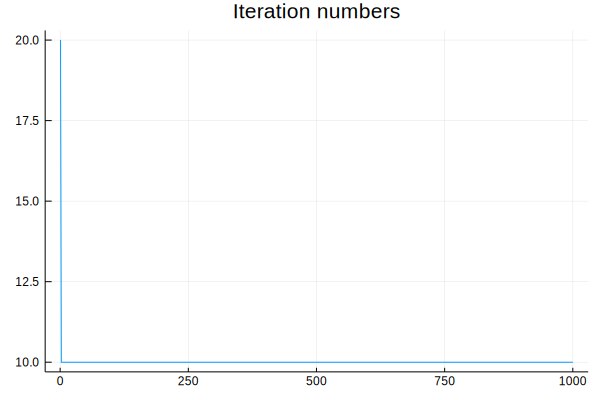

In [12]:
plot(sol1.t[2:end],iter1[2:end], title="Iteration numbers", legend=false)

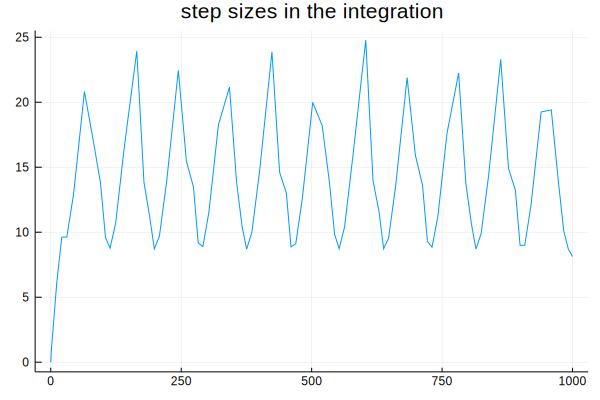

In [16]:
plot(sol1.t,steps1, title="step sizes in the integration", legend=false)

## Integration with IRKGL16 (Fixed-step)

In [44]:
dt = 10 # time-step length
(sol2,iter2,steps2)=@btime(solve(prob,IRKGL16(),adaptive=false,dt=dt,
                                 myoutputs=true,initial_interp=true));

  570.049 ms (6955281 allocations: 743.00 MiB)


In [46]:
sol2.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  7994
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          100
Number of rejected steps:                          0

### Plots

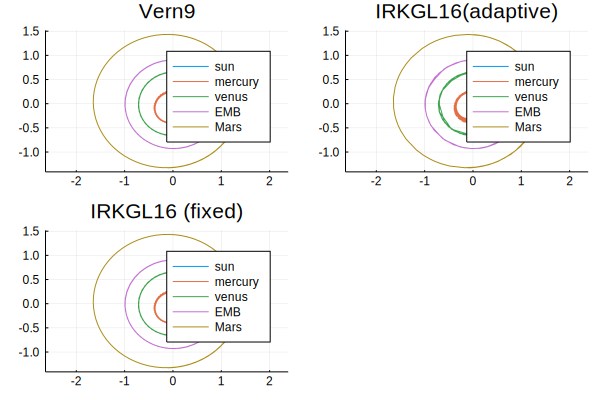

In [48]:
bodylist = ["sun", "mercury", "venus", "EMB", "Mars"]

ulist0 = sol0.u
tlist0 = sol0.t

pl1 = plot(title="Vern9",aspect_ratio=1)

for j = 1:5
 xlist  = map(u->u[2,1,j], ulist0)
 ylist  = map(u->u[2,2,j], ulist0)
 pl1 = plot!(xlist,ylist,label = bodylist[j]) 
end    


pl2 = plot(title="IRKGL16(adaptive)",aspect_ratio=1)

ulist1 = sol1.u[1:end]
tlist1 = sol1.t[1:end]

for j = 1:5
 xlist  = map(u->u[2,1,j], ulist1)
 ylist  = map(u->u[2,2,j], ulist1)
 pl2 = plot!(xlist,ylist,label = bodylist[j])
end  


pl3 = plot(title="IRKGL16 (fixed)",aspect_ratio=1)

ulist2 = sol2.u[1:end]
tlist2 = sol2.t[1:end]

for j = 1:5
 xlist  = map(u->u[2,1,j], ulist2)
 ylist  = map(u->u[2,2,j], ulist2)
 pl3 = plot!(xlist,ylist,label = bodylist[j])
end  

#plot(pl)
plot(pl1,pl2,pl3, layout=3) 

In [49]:
plot(pl2)
savefig("InnerPlanets.png")

<a href="#top">Back to the top</a>

## Error in energy

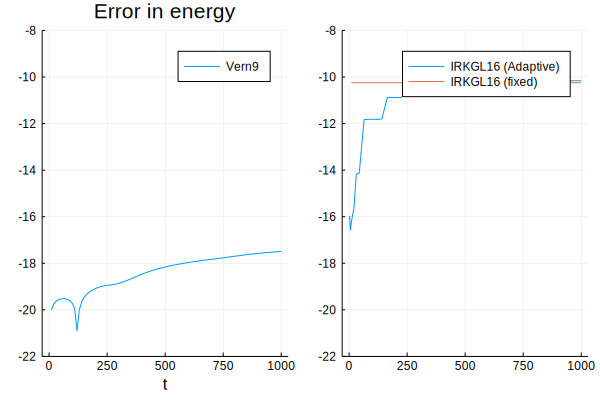

In [51]:
E0=NbodyEnergy(u0128,Gm)
end1=length(steps1)

ulist = sol0.u
tlist = sol0.t
EnergyErrors=[NbodyEnergy(BigFloat.(sol0.u[j]),Gm)/E0-1 for j in 1:length(tlist)]

ulist1 = sol1.u[1:end]
tlist1 = sol1.t[1:end]
EnergyErrors1=[NbodyEnergy(BigFloat.(sol1.u[j]),Gm)/E0-1 for j in 1:length(tlist1)]

ulist2 = sol2.u[1:end]
tlist2 = sol2.t[1:end]
EnergyErrors2=[NbodyEnergy(BigFloat.(sol2.u[j]),Gm)/E0-1 for j in 1:length(tlist2)]

ylimit1=-22
ylimit2=-8

p1=plot(tlist[1:end],log10.(abs.(EnergyErrors)),
    ylims=(ylimit1,ylimit2),
   xlabel="t", title="Error in energy", label="Vern9")
p2=plot(tlist1[1:end],log10.(abs.(EnergyErrors1)),
        ylims=(ylimit1,ylimit2),
    label="IRKGL16 (Adaptive)")
plot!(tlist2[1:end],log10.(abs.(EnergyErrors2)),
        ylims=(ylimit1,ylimit2),
    label="IRKGL16 (fixed)")
plot(p1,p2,layout=2)

In [54]:
(Float32(maximum(abs.(EnergyErrors))),Float32(maximum(abs.(EnergyErrors1))),Float32(maximum(abs.(EnergyErrors1))))

(3.2312086f-18, 6.8750936f-11, 6.8750936f-11)

## Global errror

In [40]:
# IRGL16
apr = appxtrue(sol1,test_sol)
#@show sol1[end]
#@show apr.u[end]
@show apr.errors

apr.errors = Dict(:l∞ => 0.0323455661398612500664944046868685,:L2 => 0.00360738125046282315995292046035814,:final => 1.39881853267734190295183001743949e-08,:l2 => 0.00217209998843062091859427078417135,:L∞ => 0.0761568061373032261651649382374731)


Dict{Symbol,BigFloat} with 5 entries:
  :l∞    => 0.0323456
  :L2    => 0.00360738
  :final => 1.39882e-08
  :l2    => 0.0021721
  :L∞    => 0.0761568

In [41]:
norm(sol1.u[end]-sol0.u[end])

7.16466291078776632207348942827289e-07

## Higher Order Algorithms

In [67]:
abstols = 1.0 ./ 10.0 .^ (8:14)
reltols = 1.0 ./ 10.0 .^ (8:14);
dts=20.0./2.0.^(0:length(reltols)-1)

7-element Array{Float64,1}:
 20.0   
 10.0   
  5.0   
  2.5   
  1.25  
  0.625 
  0.3125

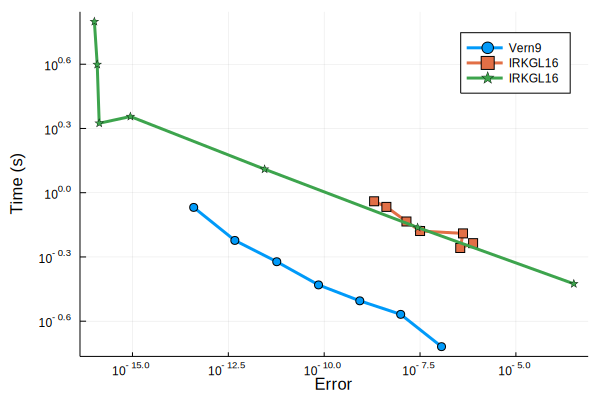

In [68]:
setups = [
#    Dict(:alg=>DP8())
          Dict(:alg=>Vern9())
#          Dict(:alg=>Vern8())   
          Dict(:alg=>IRKGL16())
          Dict(:alg=>IRKGL16(),:adaptive=>false,:dts=>dts)       
    ];
wp = WorkPrecisionSet(prob,abstols,reltols,setups;appxsol=test_sol,save_everystep=false,numruns=1)
plot(wp)